# Spectrogram Image Analysis  and Reconstruction

## By Alejandro Gómez Orjuela and Melanie Giraldo C

## Introduction

#### In this project, you will explore the intersection of image and audio processingby converting an audio file into a visual spectrogram and applying image processing techniques to enhance or alter the spectrogram. After processing theimage,you will reconstruct the original audio from the modified spectrogram.This project will help you understand the relationship between sound and itsvisual representation, while applying your knowledge of both image processing(Module 1) and audio processing (Module 2).

## Objective

#### The primary objective of this project is to convert an audio file into a spectrogram, which is an image representation of sound, and then apply image processing techniques to enhance or modify the spectrogram. After making visual modifications, the goal is to reconstruct the modified audio from the spectrogram image. Finally, the project aims to compare the original and reconstructed audio to understand the impact of the visual modifications.

## 1.Import libraries

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
import soundfile as sf
from sklearn.metrics import mean_squared_error
import librosa
from IPython.display import Audio, display


## 2.Audio to Spectrogram Conversion

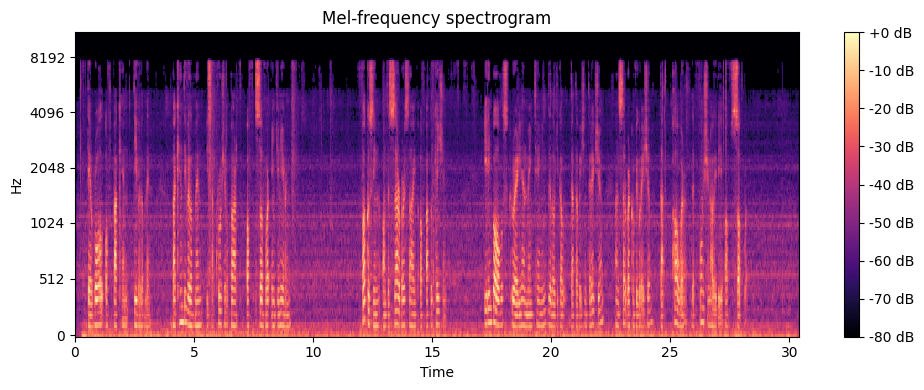

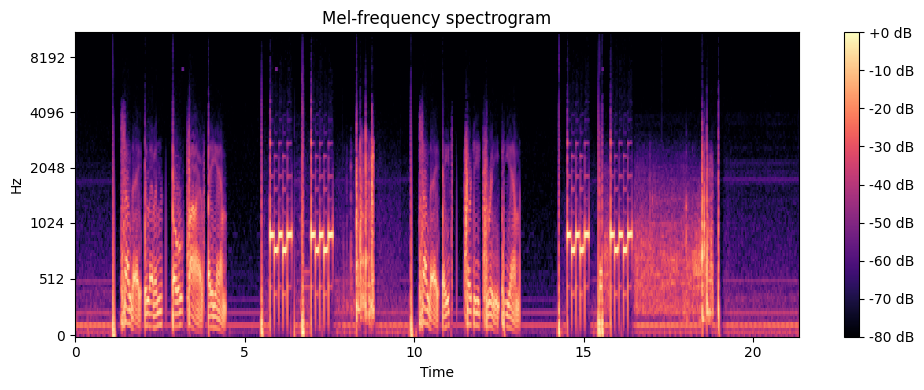

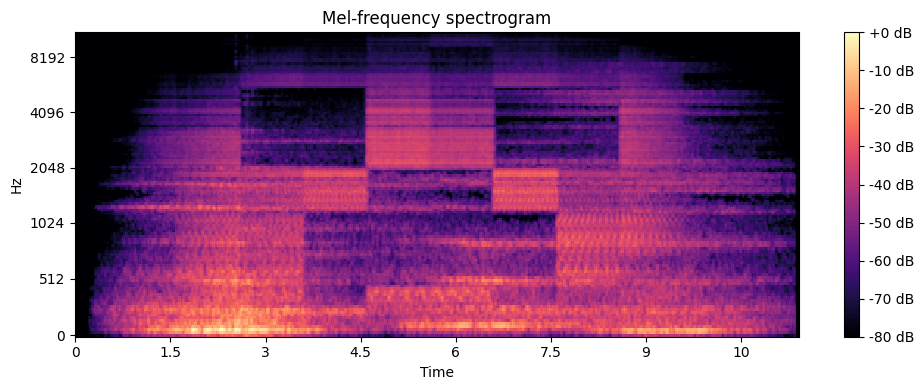

In [2]:

audio_files = ['data/audiovoice.mp3', 'data/voice.mp3', 'data/cave14.mp3']
spectrograms = []

# Convert audio to spectrogram
def audio_to_spectrogram(audio_path):
    y, sr = librosa.load(audio_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Visualizar el espectrograma
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

    return S_dB

# Convertir todos los audios a espectrogramas
for audio_file in audio_files:
    spectrograms.append(audio_to_spectrogram(audio_file))

## 3.Image processing on the spectograma

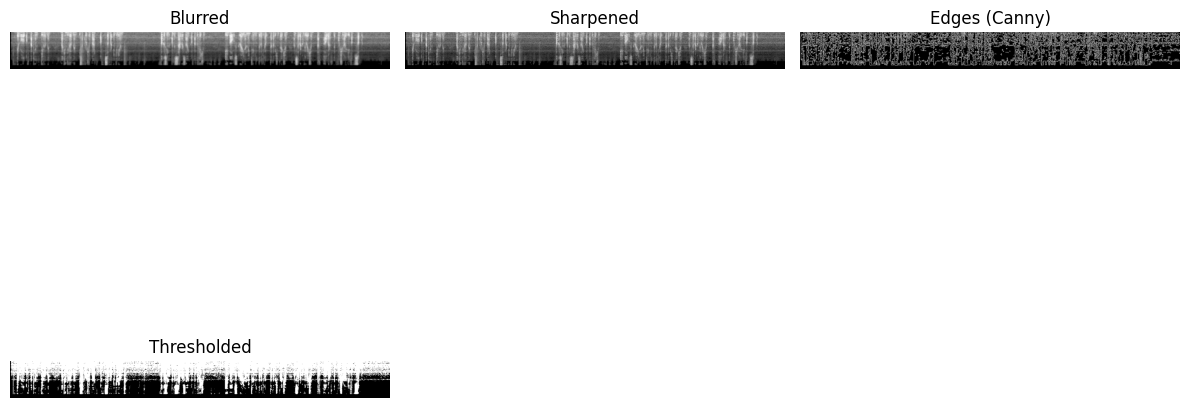

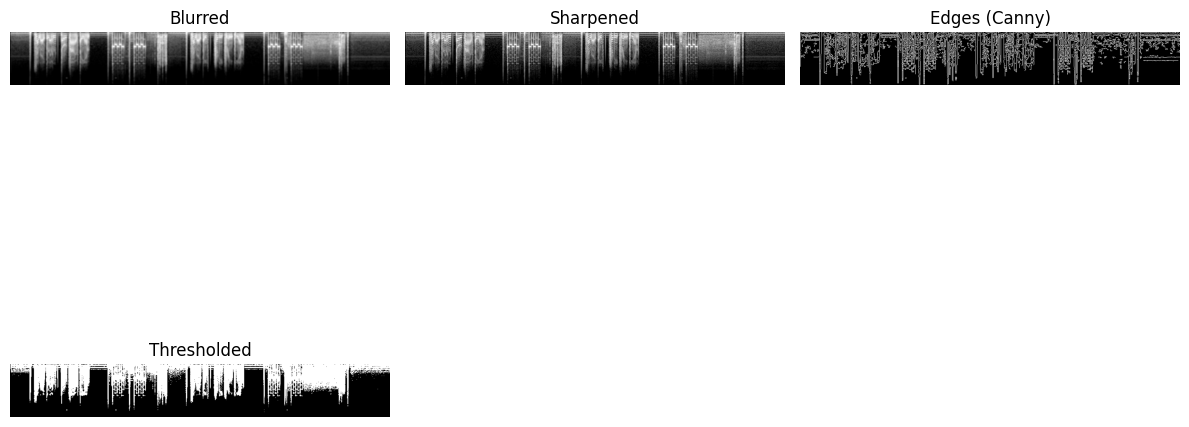

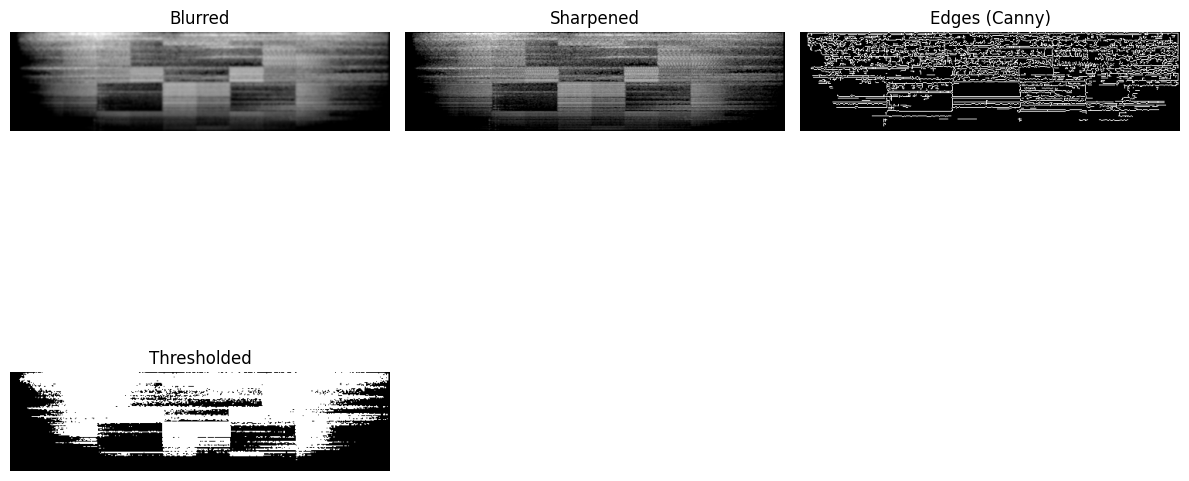

In [3]:
import cv2

processed_spectrograms = []

# Process the spectrogram
def process_spectrogram(spectrogram):
    # Convertir a imagen en escala de grises
    spectrogram_img = np.uint8(255 * (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram)))

    # Filtros de procesamiento
    blurred = cv2.GaussianBlur(spectrogram_img, (5, 5), 0)  # Desenfoque
    sharpened = cv2.addWeighted(spectrogram_img, 1.5, blurred, -0.5, 0)  # Afilar
    edges = cv2.Canny(sharpened, 100, 200)  # Detección de bordes

    # Segmentación usando umbralización
    _, thresholded = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Guardar espectrogramas procesados
    processed_spectrograms.append({
        'blurred': blurred,
        'sharpened': sharpened,
        'edges': edges,
        'thresholded': thresholded
    })

    # Visualización
    plt.figure(figsize=(12, 8))
    plt.subplot(231), plt.imshow(blurred, cmap='gray'), plt.title('Blurred'), plt.axis('off')
    plt.subplot(232), plt.imshow(sharpened, cmap='gray'), plt.title('Sharpened'), plt.axis('off')
    plt.subplot(233), plt.imshow(edges, cmap='gray'), plt.title('Edges (Canny)'), plt.axis('off')
    plt.subplot(234), plt.imshow(thresholded, cmap='gray'), plt.title('Thresholded'), plt.axis('off')
    plt.tight_layout()
    plt.show()

    return sharpened

# Procesar cada espectrograma
for spectrogram in spectrograms:
    process_spectrogram(spectrogram)




In [4]:
reconstructed_audios = []

# Reconstruct audio from processed spectrogram
def reconstruct_audio_from_spectrogram(processed_spectrogram, sr=22050):
    # Convertir de vuelta el espectrograma procesado a escala de potencia
    S_inv = librosa.db_to_power(processed_spectrogram)
    
    # Reconstruir el audio desde el espectrograma
    y_inv = librosa.feature.inverse.mel_to_audio(S_inv, sr=sr)
    
    # Reproducir el audio reconstruido
    display(Audio(y_inv, rate=sr))
    
    # Guardar el audio reconstruido
    reconstructed_audios.append(y_inv)
    
    return y_inv

# Reconstruir los audios a partir de espectrogramas procesados
for processed in processed_spectrograms:
    reconstruct_audio_from_spectrogram(processed['sharpened'], sr=22050)


Audio 1 - Original Features:
Duration: 30.40 s, Dominant Frequency: 23.55 Hz, RMS: 0.0135
Audio 1 - Reconstructed Features:
Duration: 13.96 s, Dominant Frequency: 738.33 Hz, RMS: 2118626176.0000
Mean Squared Error between original and reconstructed audio 1: 37678385518023278592.000000


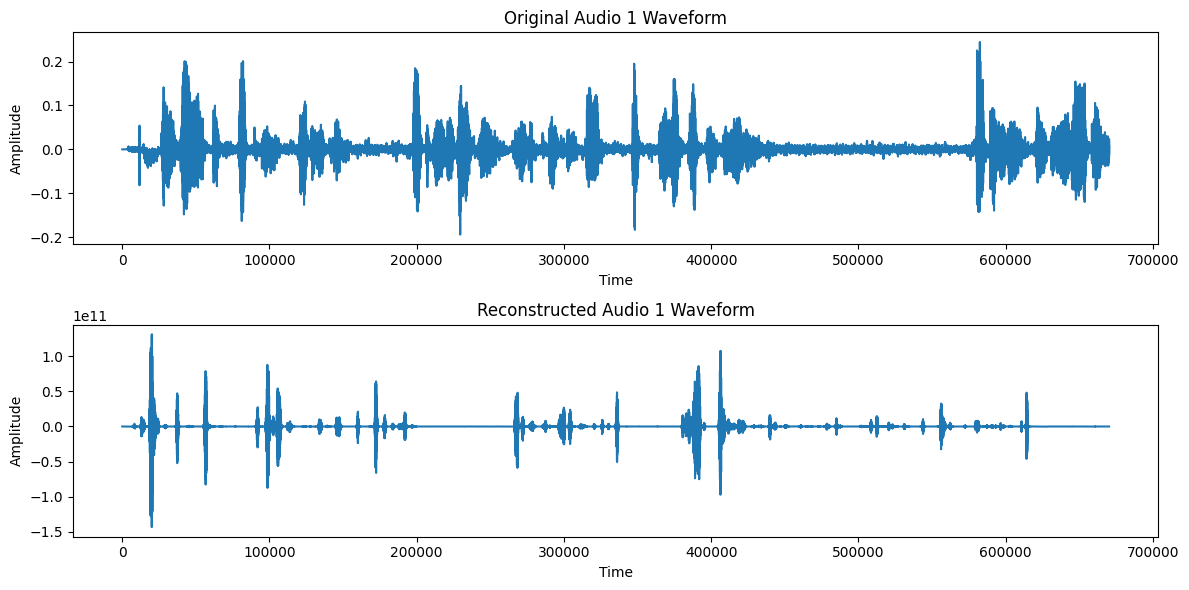

Audio 2 - Original Features:
Duration: 21.36 s, Dominant Frequency: 919.99 Hz, RMS: 0.0662
Audio 2 - Reconstructed Features:
Duration: 19.61 s, Dominant Frequency: 1010.75 Hz, RMS: 8497990656.0000
Mean Squared Error between original and reconstructed audio 2: 260924541437569138688.000000


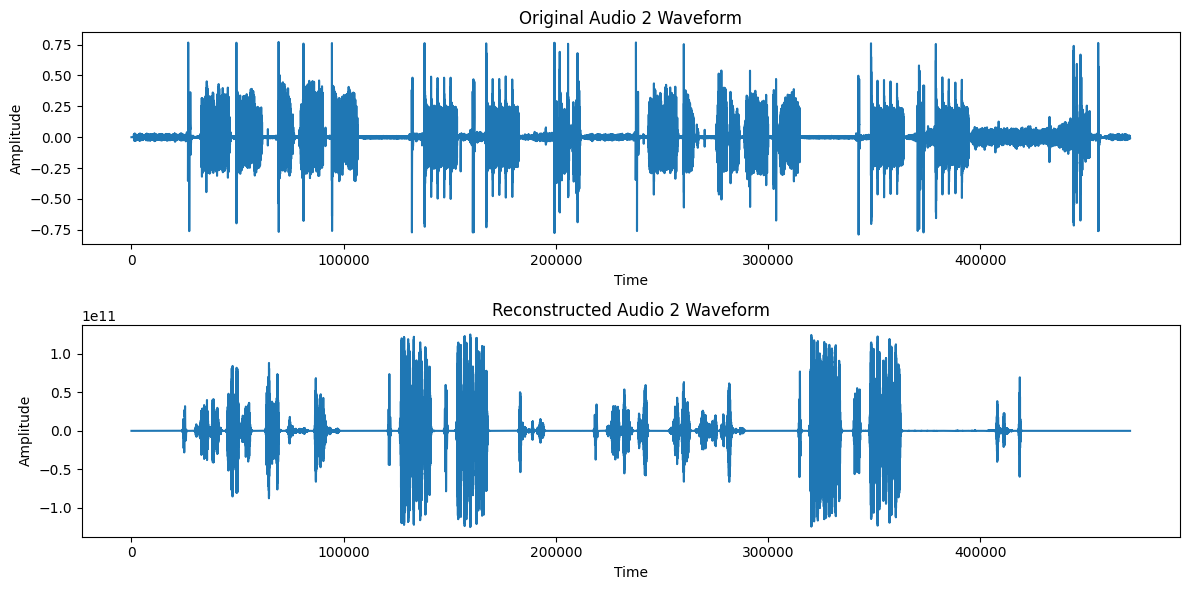

Audio 3 - Original Features:
Duration: 11.40 s, Dominant Frequency: 76.66 Hz, RMS: 0.0328
Audio 3 - Reconstructed Features:
Duration: 5.70 s, Dominant Frequency: 154.20 Hz, RMS: 2409329152.0000
Mean Squared Error between original and reconstructed audio 3: 55939919057057218560.000000


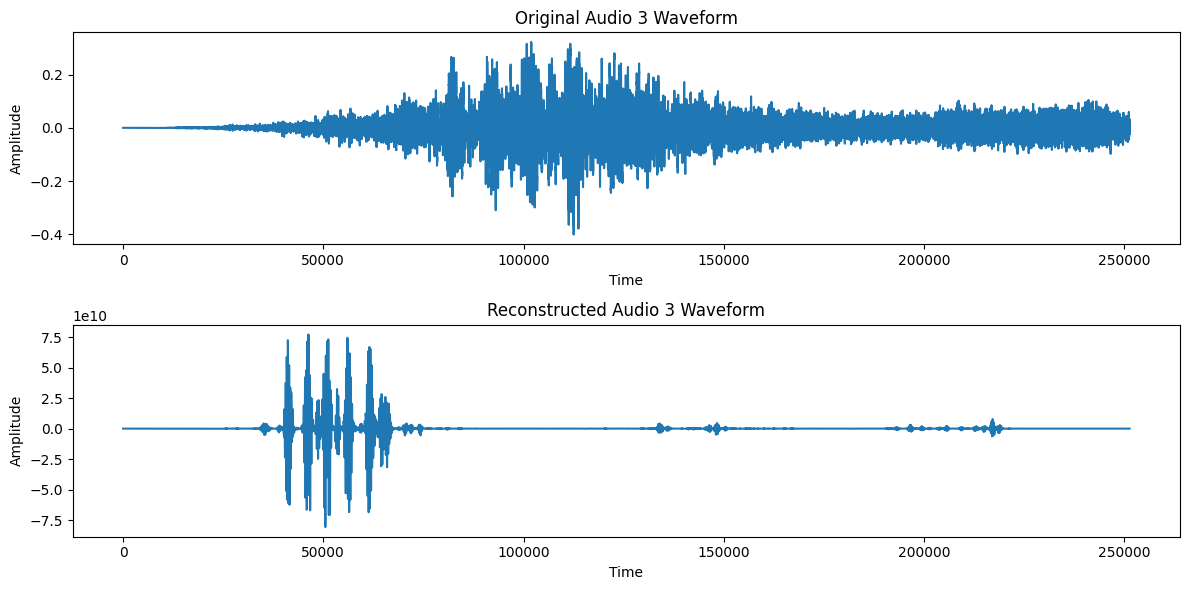

In [7]:
# Function to load audio data
def load_audio(file_path):
    signal, sr = librosa.load(file_path, sr=None)  # Load with the original sampling rate
    return signal, sr

# Load all original audios
original_audios = [load_audio(audio_file) for audio_file in audio_files]

# Function to extract audio features: duration, RMS, and dominant frequency
def extract_audio_features(signal, sr):
    # Get audio duration
    duration = librosa.get_duration(y=signal, sr=sr)

    # Compute RMS (signal power)
    rms = librosa.feature.rms(y=signal)[0]

    # Compute frequency spectrum (FFT)
    fft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(fft), 1/sr)
    
    # Get dominant frequency
    idx = np.argmax(np.abs(fft))
    dominant_freq = abs(freqs[idx])

    return duration, rms, dominant_freq

# Function to compare and plot original and reconstructed audio
def compare_and_plot(original_audio, reconstructed_audio, sr, i):
    # Extract features for original and reconstructed audios
    duration_orig, rms_orig, dominant_freq_orig = extract_audio_features(original_audio, sr)
    duration_recon, rms_recon, dominant_freq_recon = extract_audio_features(reconstructed_audio, sr)

    # Display characteristics
    print(f"Audio {i+1} - Original Features:\nDuration: {duration_orig:.2f} s, Dominant Frequency: {dominant_freq_orig:.2f} Hz, RMS: {np.mean(rms_orig):.4f}")
    print(f"Audio {i+1} - Reconstructed Features:\nDuration: {duration_recon:.2f} s, Dominant Frequency: {dominant_freq_recon:.2f} Hz, RMS: {np.mean(rms_recon):.4f}")

    # Compare RMS and duration
    min_length = min(len(original_audio), len(reconstructed_audio))
    mse = mean_squared_error(original_audio[:min_length], reconstructed_audio[:min_length])
    print(f"Mean Squared Error between original and reconstructed audio {i+1}: {mse:.6f}")

    # Plot waveforms for visual comparison
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(original_audio[:min_length])
    plt.title(f'Original Audio {i+1} Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    plt.plot(reconstructed_audio[:min_length])
    plt.title(f'Reconstructed Audio {i+1} Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Loop through all original and reconstructed audios
for i, ((original_audio, sr), reconstructed_audio) in enumerate(zip(original_audios, reconstructed_audios)):
    # Compare each pair of original and reconstructed audio
    compare_and_plot(original_audio, reconstructed_audio, sr, i)